# Image Classification, Cat and Dog

Classification has four steps
1. Setup
2. Pre-processing - data preparation
3. Model Define
4. Training
5. Post-processing - visualization

###### 1.Setup - Load the data : the Cats vs. Dogs dataset from microsoft

First, download the 786M ZIP archive of the raw data:

1-1. Raw data download

1-2. Unzip the data
unzip -q kagglecatsanddogs_5340.zip
or tar xvf kagglecatsanddogs_5340.zip

1-3. check directories
the downloaded data should be located in the same directory with jupyter notebook file (ipynb)

###### 2. Pre-processing - external libaries

tensorflow, keras, matplotlib, pydt, graphviz ... and so on
before the running, check the machine already install the libraries

In [1]:
# setup
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# for data pre-processing
import os

# for visualize data
import matplotlib.pyplot as plt

ModuleNotFoundError: No module named 'tensorflow.tsl'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


###### 2. Pre-processing - filter out corrupted images

filter out badly-encoded images


In [ ]:
import os

num_skipped = 0
for folder_name in ("Cat", "Dog"):
    folder_path = os.path.join("/content/drive/MyDrive/PetImages", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)

print("Deleted %d images" % num_skipped)

Deleted 29 images


###### 2. Pre-processing - generates a dataset for training and validation

180 x 180 image, 
batch size = 32


make a training data and validation data

In [ ]:
image_size = (180, 180)
batch_size = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/PetImages",
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/PetImages",
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 979 files belonging to 2 classes.
Using 784 files for training.
Found 979 files belonging to 2 classes.
Using 195 files for validation.


###### 2. Pre-processing - check the data status - visualize

first 9 sample images are displayed for the check, (from training dataset)

1 is "dog", 0 is "cat"

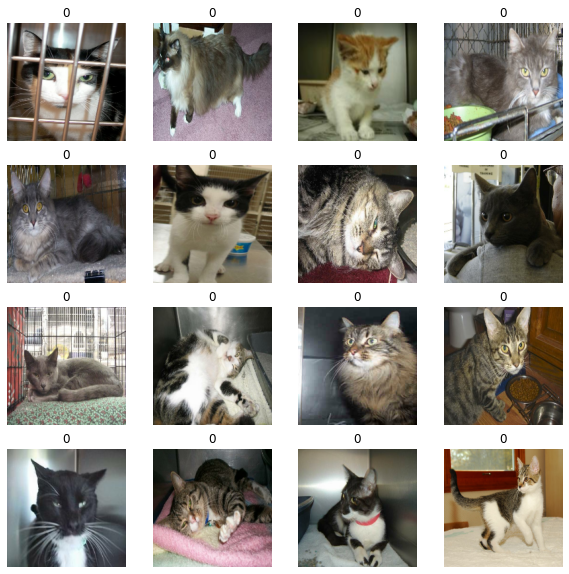

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(16):
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

###### 2. Pre-processing - data preparation

set training and validation process, if you want to add some augmented data, you can add ..

In [ ]:
train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)

###### 3. Model define

use some related alorithms such as relu, sigmoid, softmax, dropout


In [ ]:
def make_model(input_shape, num_classes):
    # Image augmentation block
    #    inputs = keras.Input(shape=input_shape)
    #    x = data_augmentation(inputs)
    inputs = keras.Input(shape=input_shape)
    x = inputs

    # Entry block
    #    x = layers.Rescaling(1.0 / 255)(x)
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=2)
# keras.utils.plot_model(model, show_shapes=True)

###### 4. Training

Model training for cat and dog

In [ ]:
epochs = 1

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics="accuracy",
)
model.fit(
    train_ds, epochs=epochs, callbacks=callbacks, validation_data=val_ds,
)


25/25 [==============================] - 193s 8s/step - loss: 0.0670 - accuracy: 0.9923 - val_loss: 0.3377 - val_accuracy: 1.0000


###### 5. Inference with new data

try to 6779.jpg for classification

In [ ]:
img = keras.preprocessing.image.load_img(
    "/content/drive/MyDrive/PetImages/Cat/1000.jpg", target_size=image_size
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
score = predictions[0]
print(
    "This image is %.2f percent cat and %.2f percent dog."
    % (100 * (1 - score), 100 * score)
)

1/1 [==============================] - 0s 368ms/step
This image is 71.94 percent cat and 28.06 percent dog.
